#### Copyright 2018 Google LLC.

# Recommendation Systems with TensorFlow

This Colab notebook complements the course on [Recommendation Systems](https://developers.google.com/machine-learning/recommendation/). Specifically, we'll be using matrix factorization to learn user and movie embeddings.



# Introduction

We will create a movie recommendation system based on the [MovieLens](https://movielens.org/) dataset available [here](http://grouplens.org/datasets/movielens/).  The data consists of movies ratings (on a scale of 1 to 5).

## Outline
  1. Exploring the MovieLens Data (10 minutes)
  1. Preliminaries (25 minutes)
  1. Training a matrix factorization model (15 minutes)
  1. Inspecting the Embeddings (15 minutes)
  1. Regularization in matrix factorization (15 minutes)
  1. Softmax model training (30 minutes)

## Setup

Let's get started by importing the required packages.

In [2]:
# @title Imports (run this cell)
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]






def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Instructions for updating:
non-resource variables are not supported in the long term
Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-rfwelk9n
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-rfwelk9n
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=730116 sha256=ff8c156f31efe5c689cfcbdf86e0a03699955b53ef22587aab4cc268f7bddaa0
  Stored in directory: /tmp/pip-ephem-wheel-cache-23buoudy/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
  Found existing installation: altair 4.1.0
    Uninstalling altair-4.1.0:
      Successfully uninstalled altair-4.1.0
Done installing Altair.


We then download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

In [3]:
# @title Load the MovieLens data (run this cell).

# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))



Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [4]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))



In [5]:
# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()



In [6]:
# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')



In [7]:
movielens.head(2)

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.000,881250949,Kolya (1996),24-Jan-1997,nan,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.000,881251577,Men in Black (1997),04-Jul-1997,nan,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,Comedy,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105


In [8]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

# I. Exploring the Movielens Data
Before we dive into model building, let's inspect our MovieLens dataset. It is usually helpful to understand the statistics of the dataset.

### Users
We start by printing some basic statistics describing the numeric user features.

In [9]:
users.describe()

,age
count,943.000
mean,34.052
std,12.193
min,7.000
25%,25.000
50%,31.000
75%,43.000
max,73.000


In [10]:
users.head(2)

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043


We can also print some basic statistics describing the categorical user features

In [11]:
users.describe(include=[np.object])

,user_id,sex,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,269,M,student,55414
freq,1,670,196,9


We can also create histograms to further understand the distribution of the users. We use Altair to create an interactive chart.

In [12]:
# @title Altair visualization code (run this cell)
# The following functions are used to generate interactive Altair charts.
# We will display histograms of the data, sliced by a given attribute.

# Create filters to be used to slice the data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')


Next, we look at the distribution of ratings per user. Clicking on an occupation in the right chart will filter the data by that occupation. The corresponding histogram is shown in blue, and superimposed with the histogram for the whole data (in light gray). You can use SHIFT+click to select multiple subsets.

What do you observe, and how might this affect the recommendations?

In [13]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

### Movies

It is also useful to look at information about the movies and their ratings.

In [14]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [15]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(2))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804


In [16]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(2))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466


Finally, the last chart shows the distribution of the number of ratings and average rating.

In [17]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

# II. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



## Sparse Representation of the Rating Matrix

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

#### Toy example
Assume we have $2$ users and $4$ movies. Our toy ratings dataframe has three ratings,

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

The corresponding rating matrix is

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

And the SparseTensor representation is,
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```



### Exercise 1: Build a tf.SparseTensor representation of the Rating Matrix.

In this exercise, we'll write a function that maps from our `ratings` DataFrame to a `tf.SparseTensor`.

Hint: you can select the values of a given column of a Dataframe `df` using `df['column_name'].values`.

In [18]:
#@title Solution
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

## Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.



### Exercise 2: Mean Squared Error

Write a TensorFlow function that takes a sparse rating matrix $A$ and the two embedding matrices $U, V$ and returns the mean squared error $\text{MSE}(A, UV^\top)$.

Hints:
  * in this section, we only consider observed entries when calculating the loss.
  * a `SparseTensor` `sp_x` is a tuple of three Tensors: `sp_x.indices`, `sp_x.values` and `sp_x.dense_shape`.
  * you may find [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd) and  [`tf.losses.mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error) helpful.

In [19]:
#@title Solution
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

Note: One approach is to compute the full prediction matrix $UV^\top$, then gather the entries corresponding to the observed pairs. The memory cost of this approach is $O(NM)$. For the MovieLens dataset, this is fine, as the dense $N \times M$ matrix is small enough to fit in memory ($N = 943$, $M = 1682$).

Another approach (given in the alternate solution below) is to only gather the embeddings of the observed pairs, then compute their dot products. The memory cost is $O(|\Omega| d)$ where $d$ is the embedding dimension. In our case, $|\Omega| = 10^5$, and the embedding dimension is on the order of $10$, so the memory cost of both methods is comparable. But when the number of users or movies is much larger, the first approach becomes infeasible.

In [20]:
#@title Alternate Solution
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

### Exercise 3 (Optional): adding your own ratings to the data set

You have the option to add your own ratings to the data set. If you choose to do so, you will be able to see recommendations for yourself.

Start by checking the box below. Running the next cell will authenticate you to your google Drive account, and create a spreadsheet, that contains all movie titles in column 'A'. Follow the link to the spreadsheet and take 3 minutes to rate some of the movies. Your ratings should be entered in column 'B'.

In [21]:
USER_RATINGS = False #@param {type:"boolean"}

In [22]:
# @title Run to create a spreadsheet, then use it to enter your ratings.
# Authenticate user.
if USER_RATINGS:
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  # Create the spreadsheet and print a link to it.
  try:
    sh = gc.open('MovieLens-test')
  except(gspread.SpreadsheetNotFound):
    sh = gc.create('MovieLens-test')

  worksheet = sh.sheet1
  titles = movies['title'].values
  cell_list = worksheet.range(1, 1, len(titles), 1)
  for cell, title in zip(cell_list, titles):
    cell.value = title
  worksheet.update_cells(cell_list)
  print("Link to the spreadsheet: "
        "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Run the next  cell to load your ratings and add them to the main `ratings` DataFrame.

In [23]:
# @title Run to load your ratings.
# Load the ratings from the spreadsheet and create a DataFrame.
if USER_RATINGS:
  my_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
  my_ratings = my_ratings[my_ratings[1] != '']
  my_ratings = pd.DataFrame({
      'user_id': "943",
      'movie_id': list(map(str, my_ratings['index'])),
      'rating': list(map(float, my_ratings[1])),
  })
  # Remove previous ratings.
  ratings = ratings[ratings.user_id != "943"]
  # Add new ratings.
  ratings = ratings.append(my_ratings, ignore_index=True)
  # Add new user to the users DataFrame.
  if users.shape[0] == 943:
    users = users.append(users.iloc[942], ignore_index=True)
    users["user_id"][943] = "943"
  print("Added your %d ratings; you have great taste!" % len(my_ratings))
  ratings[ratings.user_id=="943"].merge(movies[['movie_id', 'title']])

# III. Training a Matrix Factorization model

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```


In [24]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None







  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings




  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Exercise 4: Build a Matrix Factorization model and train it

Using your `sparse_mean_square_error` function, write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [25]:
#@title Solution
def build_model(ratings, embedding_dim=10, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

Great, now it's time to train the model!

Go ahead and run the next cell, trying different parameters (embedding dimension, learning rate, iterations). The training and test errors are plotted at the end of training. You can inspect these values to validate the hyper-parameters.

Note: by calling `model.train` again, the model will continue training starting from the current values of the embeddings.

In [26]:
#@title Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding or a movie embedding.

In [27]:
# @title User recommendations and nearest neighbors (run this cell)
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  








In [28]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  print("ids:" , ids)
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Your recommendations

If you chose to input your recommendations, you can run the next cell to generate recommendations for you.

How do the recommendations look?

### Movie Nearest neighbors

Let's look at the neareast neighbors for some of the movies.

It seems that the quality of learned embeddings may not be very good. This will be addressed in Section V by adding several regularization techniques. First, we will further inspect the embeddings.

## Movie Embedding Norm

We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items. We can confirm this hypothesis by sorting the movies by their embedding norm, as done in the next cell.

In [29]:
# @title Embedding Visualization code (run this cell)

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

Note: Depending on how the model is initialized, you may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.

Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

How does this affect the embedding norm distribution, and the ranking of the top-norm movies?

## Embedding visualization
Since it is hard to visualize embeddings in a higher-dimensional space (when the embedding dimension $k > 3$), one approach is to project the embeddings to a lower dimensional space. T-SNE (T-distributed Stochastic Neighbor Embedding) is an algorithm that projects the embeddings while attempting to preserve their pariwise distances. It can be useful for visualization, but one should use it with care. For more information on using t-SNE, see [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/).

You can highlight the embeddings of a given genre by clicking on the genres panel (SHIFT+click to select multiple genres).

We can observe that the embeddings do not seem to have any notable structure, and the embeddings of a given genre are located all over the embedding space. This confirms the poor quality of the learned embeddings. One of the main reasons, which we will address in the next section, is that we only trained the model on observed pairs, and without regularization.

In [30]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None







  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings




  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

# VI. Softmax model

In this section, we will train a simple softmax model that predicts whether a given user has rated a movie.

**Note**: if you are taking the self-study version of the class, make sure to read through the part of the class covering Softmax training before working on this part.

The model will take as input a feature vector $x$ representing the list of movies the user has rated. We start from the ratings DataFrame, which we group by user_id.

In [33]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))


In [34]:
rated_movies.head(3)

,user_id,movie_id
0,0,"[60, 188, 32, 159, 19, 201, 170, 264, 154, 116..."
1,1,"[291, 250, 49, 313, 296, 289, 311, 280, 12, 27..."
2,10,"[110, 557, 731, 226, 424, 739, 722, 37, 724, 1..."


In [35]:
rated_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 942
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   943 non-null    object
 1   movie_id  943 non-null    object
dtypes: object(2)
memory usage: 22.1+ KB


In [38]:
rated_movies.describe(include=np.object)

,user_id,movie_id
count,943,943
unique,943,943
top,269,"[173, 166, 70, 138, 673, 152, 88, 477, 657, 41..."
freq,1,1


In [39]:
rated_movies.describe()

,user_id,movie_id
count,943,943
unique,943,943
top,269,"[173, 166, 70, 138, 673, 152, 88, 477, 657, 41..."
freq,1,1


We then create a function that generates an example batch, such that each example contains the following features:
- movie_id: A tensor of strings of the movie ids that the user rated.
- genre: A tensor of strings of the genres of those movies
- year: A tensor of strings of the release year.

In [41]:
#@title Batch generation code (run this cell)
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))


### Loss function
Recall that the softmax model maps the input features $x$ to a user embedding $\psi(x) \in \mathbb R^d$, where $d$ is the embedding dimension. This vector is then multiplied by a movie embedding matrix $V \in \mathbb R^{m \times d}$ (where $m$ is the number of movies), and the final output of the model is the softmax of the product
$$
\hat p(x) = \text{softmax}(\psi(x) V^\top).
$$
Given a target label $y$, if we denote by $p = 1_y$ a one-hot encoding of this target label, then the loss is the cross-entropy between $\hat p(x)$ and $p$.

### Exercise 7: Write a loss function for the softmax model.

In this exercise, we will write a function that takes tensors representing the user embeddings $\psi(x)$, movie embeddings $V$, target label $y$, and return the cross-entropy loss.

Hint: You can use the function [`tf.nn.sparse_softmax_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits), which takes `logits` as input, where `logits` refers to the product $\psi(x) V^\top$.

In [46]:
# @title Solution
def softmax_loss(user_embeddings, movie_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

### Exercise 8: Build a softmax model, train it, and inspect its embeddings.

We are now ready to build a softmax CFModel. Complete the `build_softmax_model` function in the next cell. The architecture of the model is defined in the function `create_user_embeddings` and illustrated in the figure below. The input embeddings (movie_id, genre and year) are concatenated to form the input layer, then we have hidden layers with dimensions specified by the `hidden_dims` argument. Finally, the last hidden layer is multiplied by the movie embeddings to obtain the logits layer. For the target label, we will use a randomly-sampled movie_id from the list of movies the user rated.

![Softmax model](https://github.com/google/eng-edu/blob/master/ml/recommendation-systems/images/softmax-model.png?raw=true)

Complete the function below by creating the feature columns and embedding columns, then creating the loss tensors both for the train and test sets (using the `softmax_loss` function of the previous exercise).


In [53]:
# @title Solution

def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_movies: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
  train_batch = make_batch(train_rated_movies, 512)
  test_batch = make_batch(test_rated_movies, 256)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)

### Train the Softmax model

We are now ready to train the softmax model. You can set the following hyperparameters:
- learning rate
- number of iterations. Note: you can run `softmax_model.train()` again to continue training the model from its current state.
- input embedding dimensions (the `input_dims` argument)
- number of hidden layers and size of each layer (the `hidden_dims` argument)

Note: since our input features are string-valued (movie_id, genre, and year), we need to map them to integer ids. This is done using [`tf.feature_column.categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list), which takes a vocabulary list specifying all the values the feature can take. Then each id is mapped to an embedding vector using [`tf.feature_column.embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column).


In [54]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_movies,
      embedding_cols=[
          make_embedding_col("movie_id", 35),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])



 iteration 3000: train_loss=544.038513, test_loss=4154.372559, test_precision_at_10=0.002031

({'test_loss': 4154.3726, 'train_loss': 544.0385},
 {'test_precision_at_10': 0.0020313541319560147})

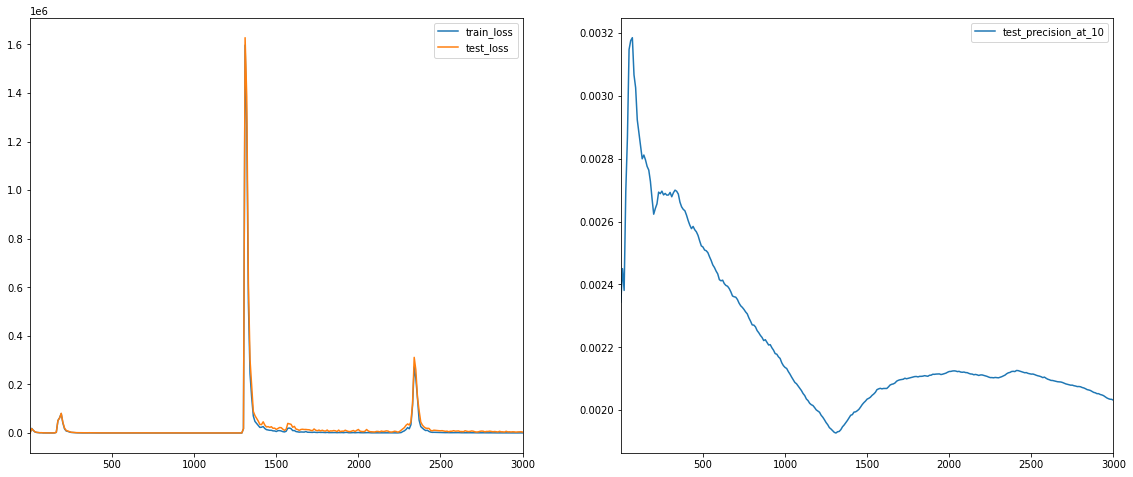

In [57]:
softmax_model.train(
    learning_rate=8.0, num_iterations=3000, optimizer=tf.train.AdamOptimizer)

### Inspect the embeddings

We can inspect the movie embeddings as we did for the previous models. Note that in this case, the movie embeddings are used at the same time as input embeddings (for the bag of words representation of the user history), and as softmax weights.

In [59]:
movie_neighbors(softmax_model, "Star Wars", DOT)
movie_neighbors(softmax_model, "Star Wars", COSINE)

ids: [49]
Nearest neighbors of : Star Wars (1977).


,dot score,titles,genres
49,675089.312,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
302,543070.812,Ulee's Gold (1997),Drama
269,539708.000,Gattaca (1997),Drama-Sci-Fi-Thriller
525,532499.875,Ben-Hur (1959),Action-Adventure-Drama
748,531580.188,"MatchMaker, The (1997)",Comedy-Romance
301,527355.188,L.A. Confidential (1997),Crime-Film-Noir-Mystery-Thriller


ids: [49]
Nearest neighbors of : Star Wars (1977).


,cosine score,titles,genres
49,1.000,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
302,0.743,Ulee's Gold (1997),Drama
202,0.719,Unforgiven (1992),Western
465,0.694,Red Rock West (1992),Thriller
704,0.686,Singin' in the Rain (1952),Musical-Romance
113,0.680,Wallace & Gromit: The Best of Aardman Animatio...,Animation


In [60]:
movie_embedding_norm([softmax_model])

alt.HConcatChart(...)

In [61]:
tsne_movie_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...
[t-SNE] Computed neighbors for 1682 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.168629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.961548
[t-SNE] KL divergence after 400 iterations: 2.788119


alt.HConcatChart(...)

## Congratulations!

You have completed this Colab notebook.

If you would like to further explore these models, we encourage you to try different hyperparameters and observe how this affects the quality of the model and the structure of the embedding space. Here are some suggestions:
- Change the embedding dimension.
- In the softmax model: change the number of hidden layers, and the input features. For example, you can try a model with no hidden layers, and only the movie ids as inputs.
- Using other similarity measures: In this Colab notebook, we used dot product $d(u, V_j) = \langle u, V_j \rangle$ and cosine $d(u, V_j) = \frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$, and discussed how the norms of the embeddings affect the recommendations. You can also try other variants which apply a transformation to the norm, for example $d(u, V_j) = \frac{\langle u, V_j \rangle}{\|V_j\|^\alpha}$.